# Learned Cost Model Evaluation

In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

pd.set_option('display.max_columns', 50)
pd.set_option('display.min_rows', 20)

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost

In [4]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [5]:
model_path = '/data/models/lcm/kcost-t20-v3/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [6]:
config['job']['LCMTrain']

{'max_epochs': 100,
 'save_dir': 'models/lcm/kcost-t20-v3',
 'use_gpu_if_avail': True,
 'model': 'Auto',
 'loss_fn': 'Huber',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/kcost-t20',
  'format': 'parquet',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/kcost-t20',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [7]:
lsm_design

'KLSM'

In [8]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)

# Loss Graph

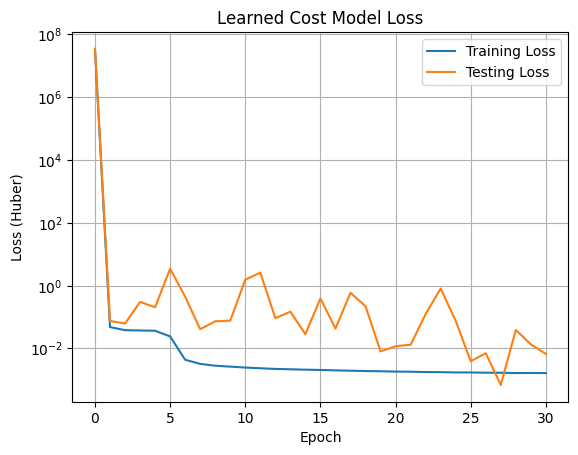

In [9]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:30]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Learned Cost Model Loss')
_ = ax.legend()
# save_fig(fig, 'learned_cost_model_loss.pdf')

In [10]:
losses.idxmin()

epoch          0
train_loss    30
test_loss     27
dtype: int64

# Building

## Model

In [11]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_10.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model(config['job']['LCMTrain']['model'])
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [12]:
model

KapModel(
  (t_embedding): Linear(in_features=20, out_features=12, bias=True)
  (k_embedding): Linear(in_features=20, out_features=12, bias=True)
  (in_norm): BatchNorm1d(262, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (in_layer): Linear(in_features=262, out_features=128, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU(inplace=True)
  )
  (out_layer): Linear(in_features=128, out_features=64, bias=True)
  (z0): Linear(in_features=16, out_features=1, bias=True)
  (z1): Linear(in_features=16, out_features=1, bias=True)
  (q): Linear(in_features=16, out_features=1, bias

In [13]:
# torchinfo.summary(model, (1, 70), device='cpu')

# Utils

In [14]:
eval_util = LCMEvalUtil(config, model, gen)

In [15]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=10.828, T=2, policy=<Policy.KHybrid: 2>, Q=1.0, Y=1.0, Z=1.0, K=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
System(E=2048, s=2.1897992232262495e-09, B=16.0, N=179169001, H=17.000196617707722, phi=1.0)


(4.363970976226787, 4.3736162185668945)

## LCM Evaluation

In [16]:
num_samples = 5000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, row['z0'], row['z1'], row['q'], row['w'])
        bad.append((norm_delta, row['z0'], row['z1'], row['q'], row['w'], design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,K_16,K_17,K_18,K_19,cost_lcm,cost_acm,delta,norm_delta
4804,0.736,0.218,0.023,0.023,8.0,4.382349e-08,8192,14.818525,644772537,0.633,20,4.0,2.0,11.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.684441,8.493571,5.809130,0.683944
4589,0.636,0.158,0.189,0.017,32.0,2.394933e-08,4096,11.787632,145840157,1.937,14,3.0,1.0,11.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.452397,5.306408,2.854011,0.537842
35,0.225,0.610,0.057,0.108,16.0,4.972055e-08,8192,10.976205,133512898,0.389,19,18.0,2.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.751908,7.903819,4.151911,0.525304
1798,0.060,0.339,0.073,0.528,64.0,6.617039e-09,2048,6.584001,297116042,0.311,16,8.0,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.941631,4.061417,2.119786,0.521933
4361,0.638,0.344,0.010,0.008,4.0,8.697548e-08,8192,18.839775,296490176,3.165,6,3.0,4.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.879104,1.800574,0.921470,0.511765
4692,0.557,0.181,0.023,0.239,8.0,4.999049e-08,8192,6.212102,423368244,3.429,10,8.0,6.0,1.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.270092,2.587871,1.317779,0.509214
2250,0.893,0.031,0.046,0.030,32.0,5.763229e-09,1024,15.835440,357611499,1.580,7,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.621796,3.208736,1.586939,0.494568
1385,0.834,0.104,0.031,0.031,8.0,3.958839e-08,8192,5.776641,156095357,0.608,6,3.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.819879,3.477751,1.657872,0.476708
2538,0.712,0.194,0.007,0.087,32.0,6.969865e-08,4096,12.262851,434052942,7.686,16,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.261268,0.495064,0.233796,0.472254
2560,0.157,0.284,0.045,0.514,8.0,1.050672e-09,8192,5.825735,810771166,0.646,11,5.0,1.0,3.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.414019,4.571619,2.157600,0.471955


In [18]:
# cost, z0, z1, q, w, design, system = bad[0]
# cost, z0, z1, q, w, design, system

In [19]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(9.676873498726026, 8.336481094360352, 0.13851502807617969)

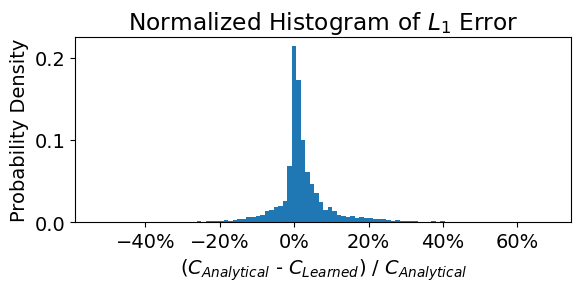

In [20]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6.4, 2.4))
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_ylabel('Probability Density')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
save_fig(fig, 'learned_cost_model_l1_error.pdf')

In [21]:
cutoff = 0.05
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 5% delta: 70.700%


In [22]:
data = df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,K_16,K_17,K_18,K_19,cost_lcm,cost_acm,delta,norm_delta
2712,0.276,0.361,0.309,0.054,128.0,9.020020e-08,1024,7.347241,136983195,6.118,11,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.623220,5.355847,-0.267373,-0.049922
1607,0.038,0.406,0.394,0.162,64.0,3.402695e-08,1024,11.059188,327841025,6.010,8,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.105614,2.005712,-0.099902,-0.049809
4487,0.622,0.111,0.075,0.192,8.0,3.700048e-08,4096,14.859684,214648809,11.645,5,4.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.377856,1.312587,-0.065269,-0.049725
4238,0.014,0.183,0.624,0.179,128.0,8.504707e-08,1024,16.103844,491464455,9.684,4,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.222768,4.975687,-0.247081,-0.049658
3693,0.480,0.383,0.058,0.079,32.0,8.276467e-09,4096,5.966138,452965280,5.421,12,1.0,4.0,4.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.623238,1.546459,-0.076778,-0.049648
289,0.527,0.026,0.268,0.179,32.0,1.574820e-08,4096,10.092670,582403603,6.947,5,3.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.635539,2.511014,-0.124525,-0.049592
2039,0.417,0.115,0.074,0.394,64.0,8.921947e-08,1024,5.901800,607804401,3.746,5,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.795778,1.711410,-0.084368,-0.049297
4887,0.125,0.078,0.369,0.428,8.0,3.842855e-08,4096,6.969024,727704646,6.130,11,1.0,6.0,10.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.745404,10.240643,-0.504762,-0.049290
416,0.158,0.045,0.794,0.003,4.0,2.379497e-08,8192,7.459675,889827321,0.885,8,2.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19.390760,18.480211,-0.910550,-0.049272
3011,0.119,0.042,0.760,0.079,16.0,6.623303e-08,8192,9.251809,640611830,3.221,3,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.976566,9.508297,-0.468269,-0.049248


In [23]:
data = df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,K_16,K_17,K_18,K_19,cost_lcm,cost_acm,delta,norm_delta
4353,0.313,0.153,0.456,0.078,16.0,2.500003e-08,8192,12.644885,694925379,8.548,4,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.458910,5.534319,-2.924591,-0.528446
1595,0.524,0.028,0.005,0.443,64.0,4.592840e-09,1024,8.200422,991285504,5.240,3,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.550955,0.379035,-0.171920,-0.453574
97,0.532,0.071,0.120,0.277,16.0,1.880013e-08,4096,9.230971,485659666,8.951,4,1.0,1.0,2.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.799691,1.962901,-0.836790,-0.426303
123,0.407,0.014,0.372,0.207,8.0,3.109411e-08,4096,9.051286,106785581,7.803,4,1.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.563322,3.915422,-1.647900,-0.420874
2688,0.104,0.307,0.563,0.026,32.0,8.107058e-09,2048,17.983947,280904679,10.284,6,1.0,5.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.289747,4.644279,-1.645468,-0.354300
3053,0.127,0.087,0.452,0.334,64.0,7.735670e-08,1024,7.861094,438382533,7.540,5,4.0,1.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.251633,5.428790,-1.822843,-0.335773
2568,0.378,0.176,0.294,0.152,32.0,6.149502e-08,4096,16.365815,778603542,9.932,5,1.0,2.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.986442,3.059649,-0.926793,-0.302908
2940,0.077,0.355,0.384,0.184,64.0,6.062967e-08,1024,8.384764,284035465,5.140,6,1.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.814082,4.468340,-1.345742,-0.301173
622,0.206,0.240,0.533,0.021,64.0,3.974382e-09,2048,19.360473,242068655,6.444,4,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.482817,4.213897,-1.268920,-0.301127
2032,0.188,0.270,0.434,0.108,64.0,4.136379e-08,1024,13.521318,296298298,10.730,7,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.408257,2.620398,-0.787859,-0.300664


In [24]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

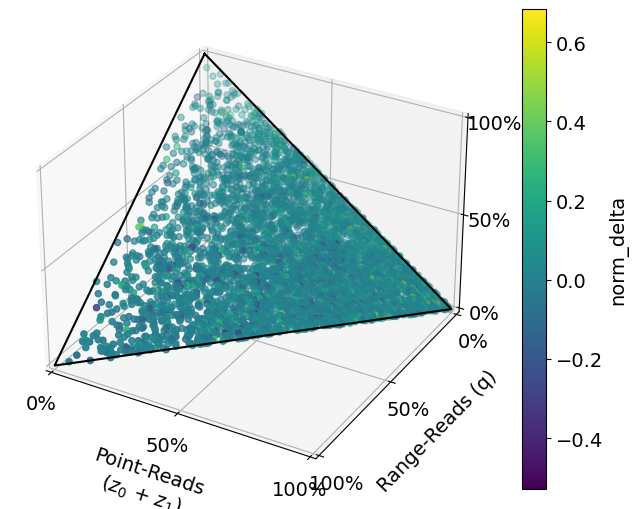

In [25]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

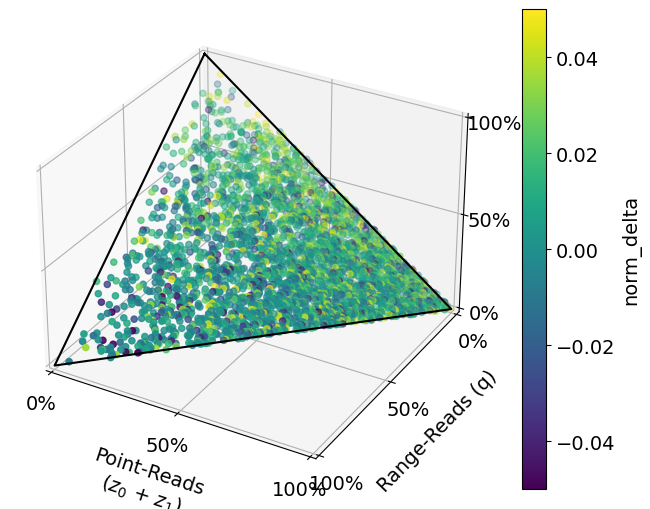

In [26]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)], 'norm_delta')

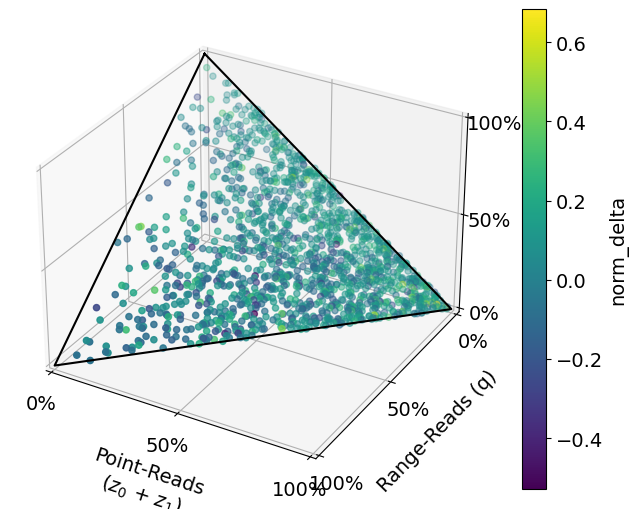

In [27]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)], 'norm_delta')

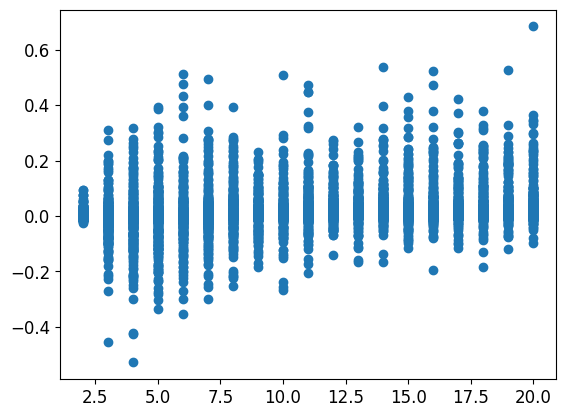

In [28]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['T'], df.norm_delta)
None

In [29]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(9.676873498726026, 8.336481094360352, 0.13851502807617969)

In [30]:
[eval_util.cf.Z0(design, system), eval_util.cf.Z1(design, system), eval_util.cf.W(design, system), eval_util.cf.Q(design, system)] 

[1.0232150466209842, 1.4729366898362173, 0.8465909829586964, 19.03980074745682]